In [1]:
%matplotlib inline
import math
import torch 
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
batch_size,num_steps = 32,35  # 输入矩阵32*35
train_iter,vocab = d2l.load_data_time_machine(batch_size,num_steps)

In [3]:
d2l.load_data_time_machine??

Signature:
d2l.load_data_time_machine(
    batch_size,
    num_steps,
    use_random_iter=False,
    max_tokens=10000,
)
Source:   
def load_data_time_machine(batch_size, num_steps,
                           use_random_iter=False, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset.

    Defined in :numref:`sec_language_model`"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab
File:      d:\anaconda\envs\pytorch\lib\site-packages\d2l\torch.py
Type:      function

In [4]:
# 独热编码
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [5]:
X = torch.arange(10).reshape((2,5))
print(X.T)
F.one_hot(X.T,28).shape
print(F.one_hot(X.T,28))

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]])
tensor([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

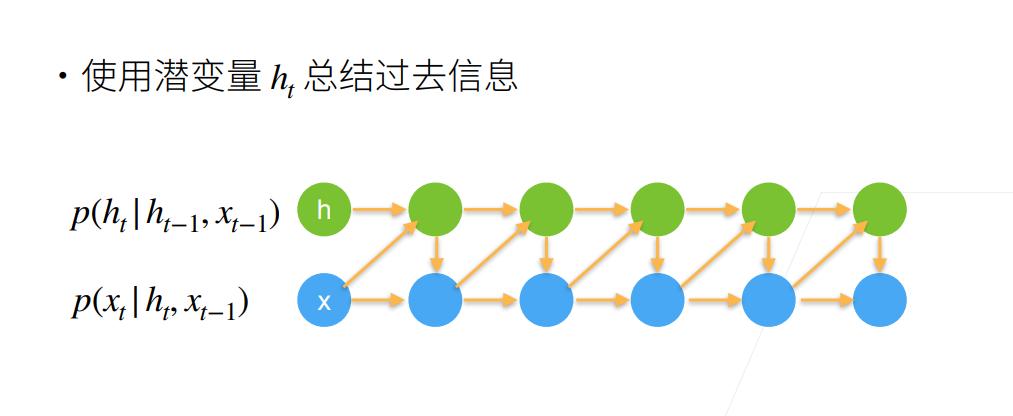
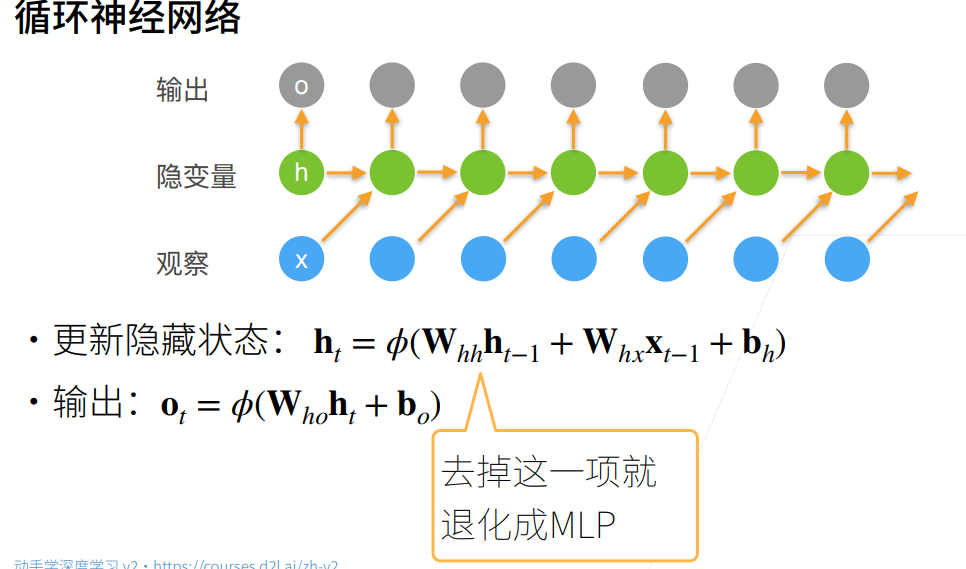
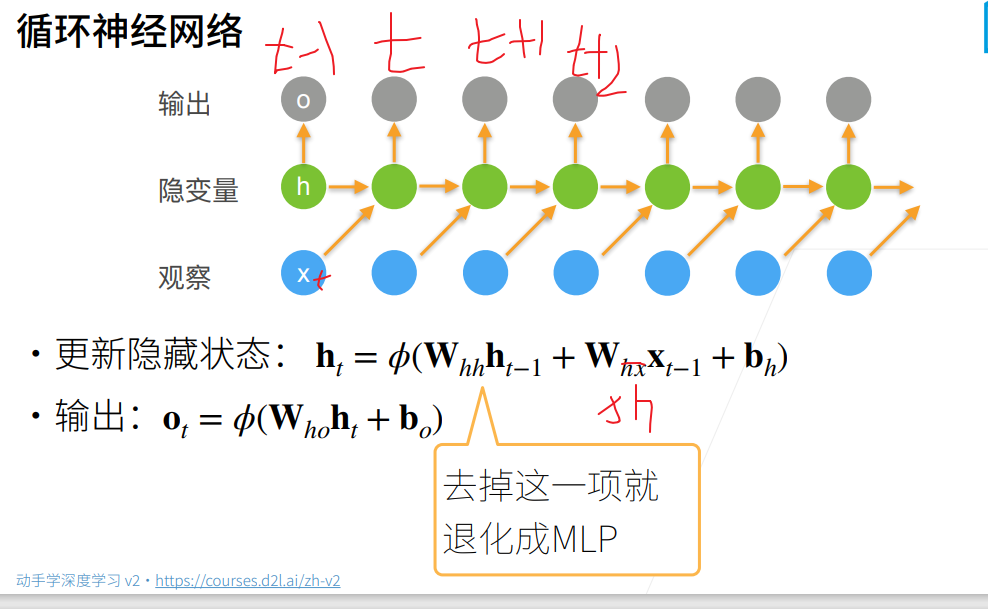

In [6]:
# 初始化循环神经网络的模型参数
def get_params(vocab_size,num_hiddens,device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)*0.1
    
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens,num_hiddens))
    b_h = torch.zeros(num_hiddens,device = device)
    W_hq = normal((num_hiddens,num_outputs))
    b_q = torch.zeros(num_outputs,device=device)
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params 

In [7]:
# 一个init_rnn_state 函数在初始化时返回隐藏状态
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),) # t = 0 时候的隐藏层

In [8]:
# 下面的rnn函数定义了如何在下一个时间步计算隐藏状态和输出
def rnn(inputs,state,params):
    W_xh,W_hh,b_h,W_hq,b_q = params
    H,= state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y = torch.mm(H,W_hq)+b_q
        outputs.append(Y)
    return torch.cat(outputs,dim=0),(H,)

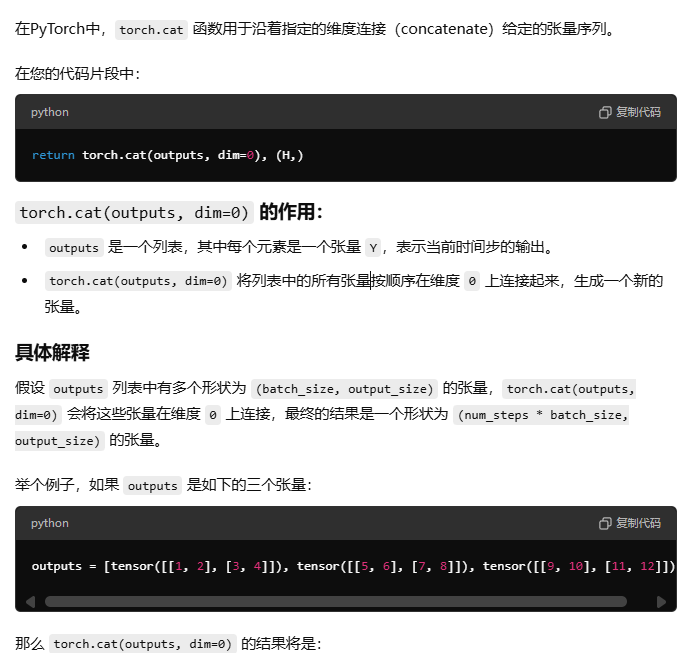
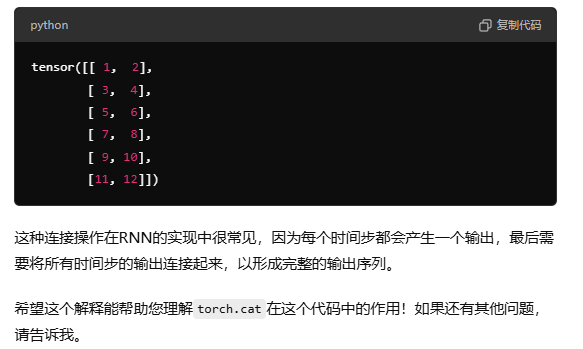

In [9]:
# 创建一个类来包装这些函数
class RNNModelScratch:
    """从零开始实现的循环神经网络"""
    def __init__(self,vocab_size,num_hiddens,device,get_params,
                 init_state,forward_fn):
        self.vocab_size,self.num_hiddens = vocab_size,num_hiddens
        self.params = get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn = init_state,forward_fn
    
    def __call__(self,X,state):
        X = F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [10]:
# 检查输出是否具有正确的形状
num_hiddens = 512
net = RNNModelScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,
                      init_rnn_state,rnn)
state = net.begin_state(X.shape[0],d2l.try_gpu())

Y,new_state = net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [11]:
# 首先定义预测函数来生成用户提供的prefix之后的新字符
def predict_ch8(prefix,num_preds,net,vocab,device):
    """在prefix 后面生成新字符"""
    state = net.begin_state(batch_size=1,device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]],device=device).reshape((1,1))

    for y in prefix[1:]:
        _,state = net(get_input(),state) # 预热
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y,state= net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_ch8('time traveller ',10,net,vocab,d2l.try_gpu())

'time traveller nw  <unk>wzgyu'

# 梯度裁剪
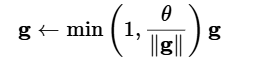

In [12]:
def grad_clipping(net,theta):
    """裁剪梯度"""
    if isinstance(net,nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm >theta:
        for param in params:
            param.grad[:] *= theta/norm

In [13]:
# 定义一个函数来训练只有一个迭代周期的模型
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    """训练模型一轮的一个迭代周期"""
    state,timer = None,d2l.Timer()
    metric = d2l.Accumulator(2)
    for X,Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0],device=device)
        else:
            for s in state:
                s.detach_()
        y = Y.T.reshape(-1)
        X,y = X.to(device),y.to(device)
        y_hat,state = net(X,state)
        l = loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        metric.add(1*y.numel(),y.numel())
    return math.exp(metric[0]/metric[1]),metric[1]/timer.stop()

In [14]:
# 训练函数支持从零开始或使用高级API实现的循环神经网络模型
def train_ch8(net,train_iter,vocab,lr,num_epochs,device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',ylabel='perplexity',
                            legend=['train'],xlim=[10,num_epochs])
    if isinstance(net,nn.Module):
        updater = torch.optim.SGD(net.parameter(),lr)
    else:
        updater = lambda batch_size:d2l.sgd(net.params,lr,batch_size)
    predict = lambda prefix:predict_ch8(prefix,50,net,vocab,device)
    for epoch in range(num_epochs):
        ppl,speed = train_epoch_ch8(net,train_iter,loss,updater,device,
                                    use_random_iter)
        if(epoch+1)%10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1,[ppl])
    print(f'困惑度{ppl:lf},{speed:lf} 标记/秒{str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

ValueError: Invalid format specifier

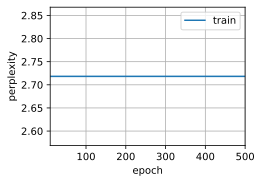

In [15]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())